#✨뉴스 요약하는 모델을 만들어보자!
####이번 프로젝트는 **뉴스를 요약하는 모델을 만드는 것**입니다.
####실제로 뉴스 요약은 **인터넷에서 많이 쓰이고 있습니다**.
####**seq2seq와 어텐션 메커니즘으로 추상적 요약**을 해보고
####summa 라이브러리 통해 추출적 요약을 해보도록 하겠습니다.
####더 나아가서는 한국어로 뉴스 요약도 진행해보겠습니다.
####그리고 인터넷을 찾아보니 **simplet5라는 라이브러리로 엄청 간단하게 모델 구현이 가능합니다**.
####**simplet5를 사용한 파이토치 모델을 한번 만들어보겠습니다**.





##✅목차
- 사전 준비하기!
- 데이터 전처리를 해보자!
- 텍스트 태깅을 해보자!
- 학습 데이터와 테스트 데이터로 분할
- 데이터 전처리 - 토크나이저
- 추상적 요약 모델 설계 및 학습과 결과 확인
- 추출적 요약
- simplet5를 사용한 파이토치 모델 구현(캐글 참고)
- 한국어로 된 기사를 요약해보자!
- 마무리


---

#사전 준비하기!

##한국어 태깅을 위한 라이브러리 설치

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 7.0 MB/s 
     |████████████████████████████████| 453 kB 56.2 MB/s 


추후에 한국어로 작성된 뉴스기사도 요약을 해볼것이기 때문에 **한국어 관련 라이브러리도 설치해줍니다**.

---

##구글 드라이브 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

##뉴스 데이터 파일 압축해제

In [ ]:
%cd "/content/drive/MyDrive/pic/ex"
!unzip "archive (1).zip"

/content/drive/MyDrive/pic/ex
Archive:  archive (1).zip
  inflating: news_summary.csv        
  inflating: news_summary_more.csv   


전 캐글에서 압축 파일로 다운을 받았습니다.

그래서 압축을 풀어주도록 하겠습니다.

---

##필요한 라이브러리 임포트

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


본격적인 코딩에 들어가기전에 사용할 라이브러리들을 미리 임포트 시켜줍니다.

---

#데이터 전처리를 해보자!

##데이터 확인

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pic/ex/news_summary_more.csv')
df.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


이번 프로젝트에서는 **news_summary_more파일만 사용**한다고 했습니다.

제대로 압축이 풀렸는지 데이터는 제대로 있는지 확인을 해줍니다.

In [ ]:
print(len(df))

98401


총 **98401개의 행으로 이루어진 csv 파일인거 같습니다**.

많은거 같기도하고 아닌거 같기도 하네요


In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', df['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', df['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


---

##null값, 불용어 제거

In [ ]:
#isnull을 이용하면 결측치를 확인할 수 있다.
print(df.isnull().sum())

headlines    0
text         0
dtype: int64


**text랑 headlinese에서 결측치는 없는것으로 확인**이 됩니다.

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어란?

**stopwords 또는 불용어 란, 우리가 언어를 분석할 때, 의미가 있는 단어와, 의미가 없는 단어나 조사 등**이 있습니다. 

이렇게 의미가 없는 것들을 **stopwords** 라고 합니다.

**text에서는 불용어 사전에 정의된 것을 다 삭제하고 진행**하겠습니다.

----

##텍스트 전처리

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # headlines의 경우에는 불용어 미제거
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 함수를 위와 같이 만들어봤습니다. 저 함수는
- 모든 영어 문자를 소문자로 변환
- 종종 포함되어있는 html 태그 제거
- 정규 표현식을 이용하여 특수문자 제거
- text에서는 불용어를 모두제거 headlines에는 자연스럽게 보이기 위해 제거하지 않는것이 좋음


이러한 기능들을 수행합니다.

---

##멀티프로세싱을 활용한 병렬처리

In [ ]:
import multiprocessing as mp  
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 함

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(df, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(df, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(df['text'])  
print(clean_text)

clean_headlines = preprocess_data(df['headlines'], remove_stopwords=False) 
print(clean_headlines)

731.2269108295441  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

실행시간이 총 760초로 나왔습니다.
분으로 환산하면 대략 13분 정도가 걸린것인데....빠른건지 잘 모르겠네요

In [ ]:
df['text'] = clean_text
df['headlines'] = clean_headlines

# 빈 샘플값을 NULL 값으로 변환
df.replace('', np.nan, inplace=True)

**정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우**가 있을 수 있습니다.

그럼 그 **문장은 빈 샘플**을 가지고 있게 됩니다.

이러한 경우를 고려하여 **빈 값을 가진 샘플이 있다면, 모두 NULL값을 가진 샘플로 대체**시킵니다.

---

#텍스트 태깅을 해보자!

뉴스 요약문을 만들때 생각을 해보았습니다.

만약 한국 월드컵 우승이 요약문으로 나와야하는데

**한국이라는 문자가 기사에 적게 나온다면 월드컵 우승이라고만 나올수도 있습니다**.

즉, **이번 데이터에서 고유명사는 얼마나 나오는지 한번 확인**해보겠습니다.

---

##text 전체를 태깅

In [ ]:
#텍스트를 리스트 형태로 변환해서 뛰어쓰기별로 분리시킵니다.
text_1 = str(df['text'].values.tolist())
text_2 = text_1.split()
#nltk라는 라이브러리의 pos_tag를 사용하면 텍스트의 종류를 알 수 있습니다.
tag_word = nltk.pos_tag(text_2)

tag_df1 = pd.DataFrame({'tag_word': tag_word})
tag_df1

,tag_word
0,"(['saurav, NN)"
1,"(kant, JJ)"
2,"(alumnus, NN)"
3,"(upgrad, JJ)"
4,"(iiit, JJ)"
...,...
3453854,"(withdrawal, JJ)"
3453855,"(support, NN)"
3453856,"(immediate, JJ)"
3453857,"(threat, NN)"


3453858개의 단어가 나왔네요.......

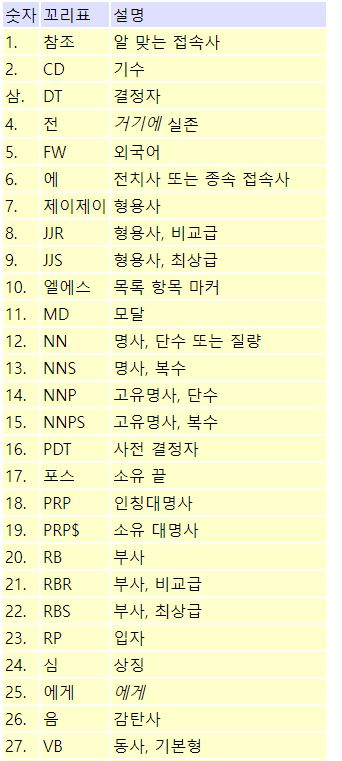

https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

링크에 들어가보시면 알수있습니다.

**(withdrawal, JJ) 뒤에 JJ는 표에서 형용사** 인걸 알 수 있습니다.

현재는 너무 많으니 저는 **NN(명사)과 NNP(고유명사)를 기준으로 확인해보겠습니다**.

---

##NN(명사)만 태깅

In [ ]:
NN_words = []
for word, pos in tag_word:
    if 'NN' in pos:
        NN_words.append(word)
tag_df_NN = pd.DataFrame({'NN': NN_words})

tag_df_NN

,NN
0,['saurav
1,alumnus
2,pg
3,program
4,machine
...,...
1726802,bill
1726803,seats
1726804,support
1726805,threat


**1726806개**가 나오네요

한번 text전체에서 비중은 어떤식으로 이루어지는지 봐볼까요?

In [ ]:
x = tag_df_NN['NN'].value_counts()
x

year            14791
people          10519
government      10377
police           9594
minister         9445
                ...  
bhusawar            1
withdrawal',        1
dunno               1
overview            1
government']        1
Name: NN, Length: 68462, dtype: int64

**year하고 people이 가장 많이 쓰이고 있는거 같습니다**.

이번에는 **워드 클라우드**로 확인해보겠습니다.

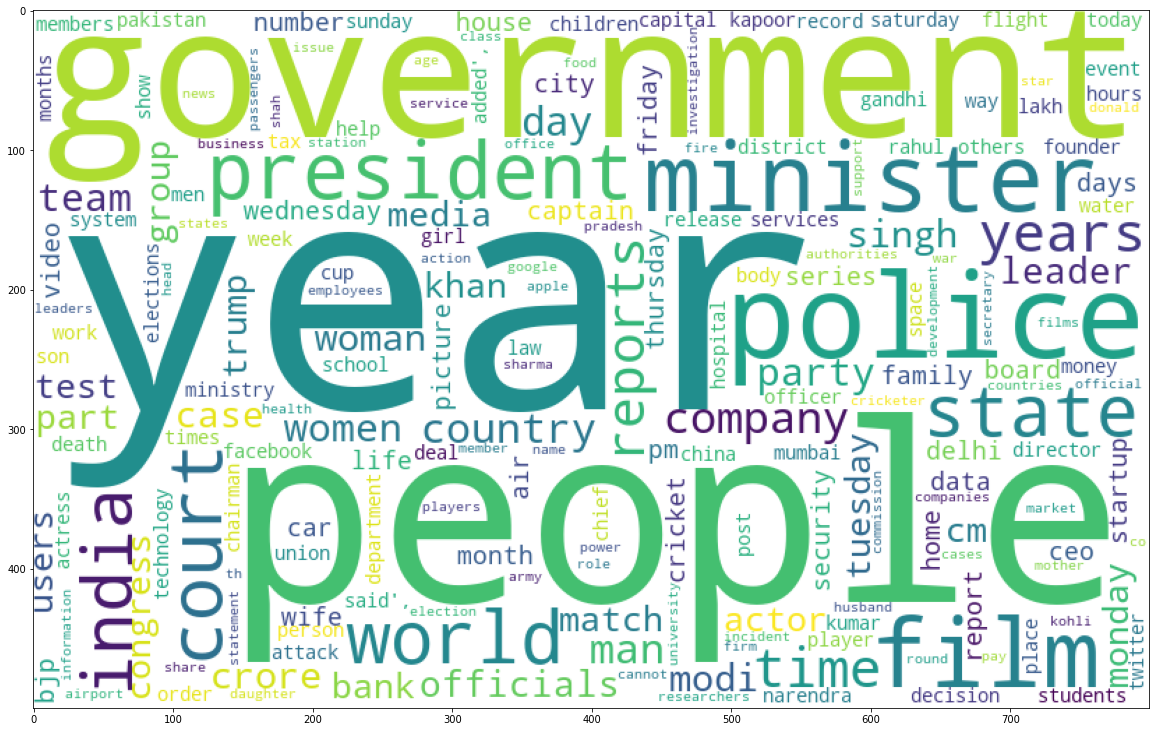

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color = 'white', width = 800, height = 500)
cloud = wc.fit_words(dict(x))
plt.figure(figsize=(20,15))
plt.imshow(cloud)

워드 클라우드란?

**문서의 키워드, 개념 등을 직관적으로 파악할수 있도록 핵심 단어**나 많이 언급되는 단어를

**크게 표현하여 한눈에 들어올 수 있게 하는 기법**입니다.

**year나 people이 빈도수가 많으니 당연히 크게 보여지는군요**

---

##NNP(고유명사)만 태깅

In [ ]:
NNP_words = []
for word, pos in tag_word:
    if 'NNP' in pos:
        NNP_words.append(word)
tag_df_NNP = pd.DataFrame({'NNP': NNP_words})

tag_df_NNP

,NNP
0,'pakistani
1,'india
2,'louis
3,'jibe
4,zealand
...,...
19311,janata
19312,karnataka
19313,'censor
19314,yogi


이번에는 **고유명사만 출력**해보았습니다.

확실히 많이 줄어들었습니다.

이번 단어는 얼마나 나왔는지 확인해보죠

In [ ]:
y = tag_df_NNP['NNP'].value_counts()
y

'india       855
khan         853
yogi         413
'actor       381
'us          378
            ... 
'sitaram       1
'flyer         1
karz           1
'reporter      1
'braille       1
Name: NNP, Length: 3324, dtype: int64

가장 많은게 855네요?

이럼 **고유명사는 뉴스 요약문을 생성할때 다 지워지게 되는 걸까요?**

그것도 한번 생각해보는게 좋을꺼 같습니다.

이 결과도 워드 클라우드로 시각화를 해보겠습니다.

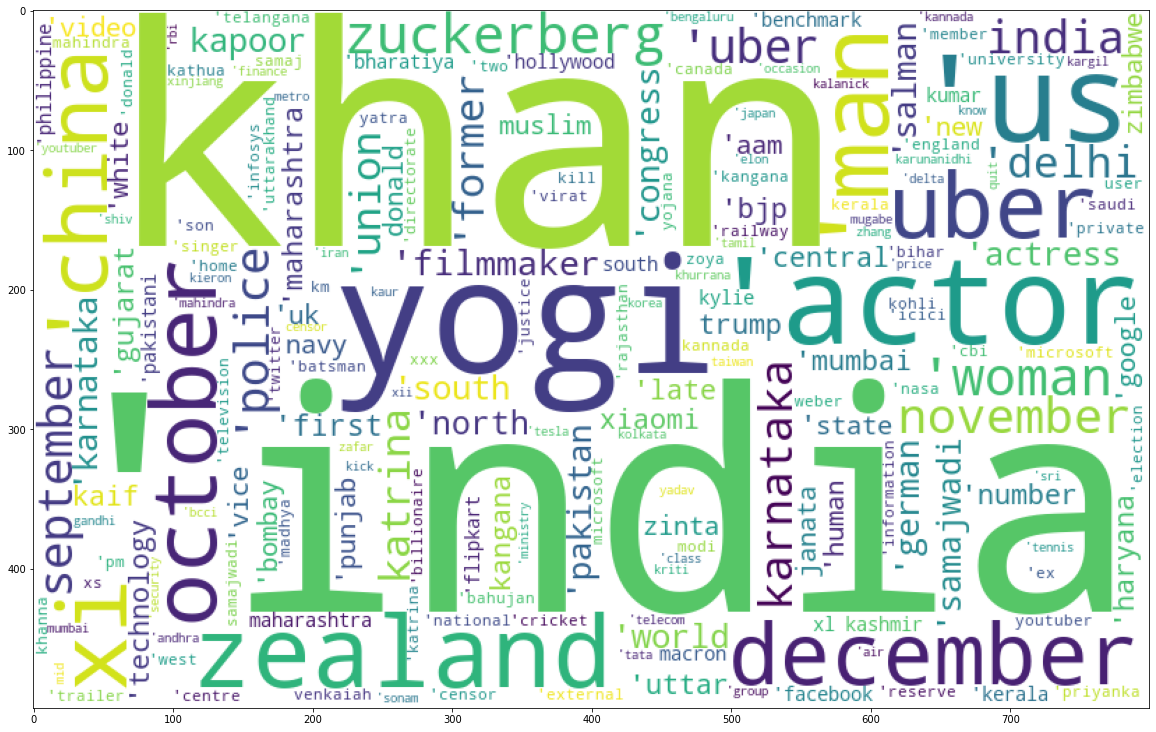

In [ ]:
wc = WordCloud(background_color = 'white', width = 800, height = 500)
cloud = wc.fit_words(dict(y))
plt.figure(figsize=(20,15))
plt.imshow(cloud)

---

##headlines에서 태깅

In [ ]:
headlines_1 = str(df['headlines'].values.tolist())
headlines_2 = headlines_1.split()
tag_headlines = nltk.pos_tag(headlines_2)

headlines_df1 = pd.DataFrame({'tag_headlines': tag_headlines})
headlines_df1

,tag_headlines
0,"(['upgrad, JJ)"
1,"(learner, NN)"
2,"(switches, NNS)"
3,"(to, TO)"
4,"(career, VB)"
...,...
915090,"(withdraws, VBZ)"
915091,"(support, NN)"
915092,"(to, TO)"
915093,"(nepalese, JJ)"


915094개의 단어가 나왔네요

##NN(명사)만 태깅

In [ ]:
NN_words_test = []
for word1, pos1 in tag_headlines:
    if 'NN' in pos1:
        NN_words_test.append(word1)
tag_df_test_NN = pd.DataFrame({'NN': NN_words_test})

tag_df_test_NN

,NN
0,learner
1,switches
2,al
3,"hike',"
4,techie
...,...
364919,trump
364920,"video',"
364921,morcha
364922,support


In [ ]:
tag_df_test_NN['NN'].value_counts()

man             1906
world           1786
india           1333
pm              1326
woman           1274
                ... 
varieties          1
mister             1
mask',             1
'hefner            1
government']       1
Name: NN, Length: 33995, dtype: int64

headlines에서는 man, world등이 명사중에서 가장 많이 나오는 단어인거 같습니다.

고유명사도 확인해볼까요?


---

##NNP(고유명사)만 태깅

In [ ]:
NNP_words_test = []
for word1, pos1 in tag_headlines:
    if 'NNP' in pos1:
        NNP_words_test.append(word1)
tag_df_test_NNP = pd.DataFrame({'NNP': NNP_words_test})

tag_df_test_NNP

,NNP
0,zealand
1,'india
2,'man
3,'pakistan
4,'woman
...,...
8018,'donald
8019,'man
8020,'video
8021,'censor


In [ ]:
tag_df_test_NNP['NNP'].value_counts()

'india       822
'man         529
'uber        283
'woman       219
'china       203
            ... 
'lsd           1
'uco           1
'karti         1
zayn           1
'lipstick      1
Name: NNP, Length: 1950, dtype: int64

**text에 고유명사랑 갯수차이는 나지만 각 단어별 빈도수는 그렇게 큰 차이가 나지는 않는거 같습니다**.

---

##text에서 단어의 갯수 확인

In [ ]:
text_1 = str(df['text'].values.tolist())
text_2 = text_1.split()

df1 = pd.DataFrame({'word': text_2})
df1

,word
0,['saurav
1,kant
2,alumnus
3,upgrad
4,iiit
...,...
3453854,withdrawal
3453855,support
3453856,immediate
3453857,threat


In [ ]:
df1['word'].value_counts()

said               49355
india              16177
year               14791
also               14300
added              12889
                   ...  
'vvip                  1
proportionately        1
'hyatt                 1
wedging                1
government']           1
Name: word, Length: 97579, dtype: int64

**text전체에서 단어를 살펴본 결과 said가 가장 많이 나오는걸 알 수 있습니다**.

과연 **said가 핵심 단어** 일까요?

결과는 나중에 살펴보도록하겠습니다.

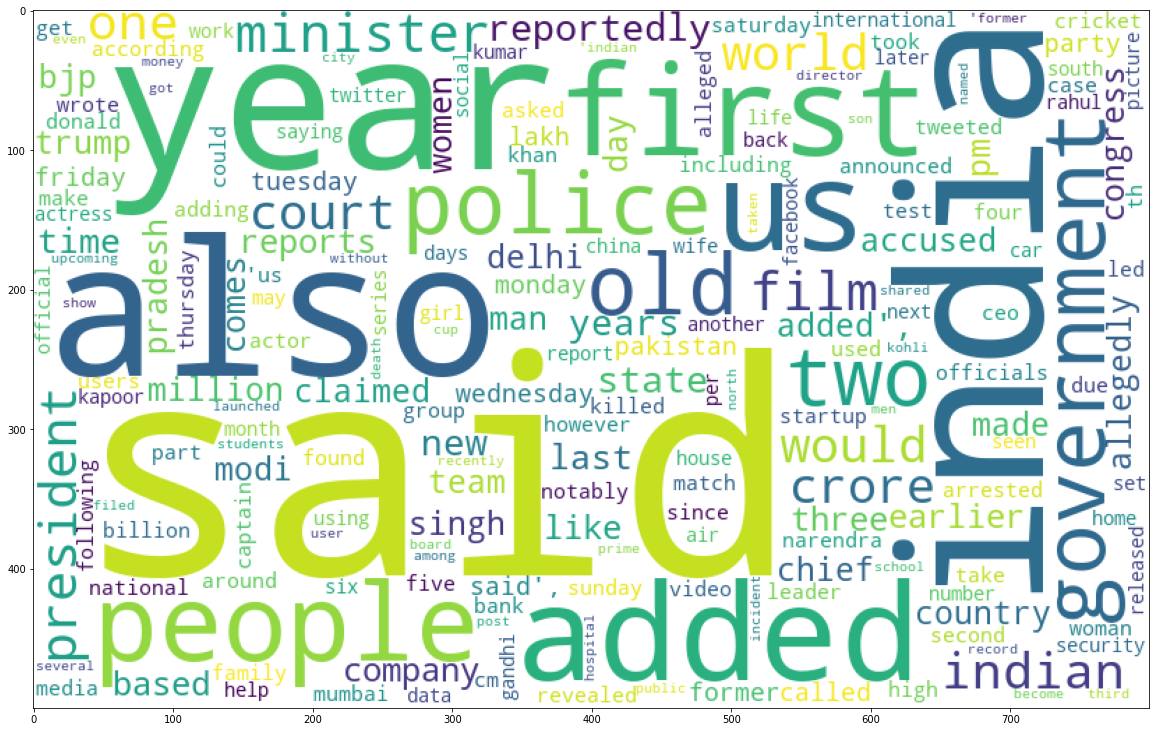

In [ ]:
x1 = df1['word'].value_counts()

wc = WordCloud(background_color = 'white', width = 800, height = 500)
cloud = wc.fit_words(dict(x1))
plt.figure(figsize=(20,15))
plt.imshow(cloud)

빈도수를 본 결과 가장 많이 나온건 said네요

두번째는 **india인데 뭔가 이상하지 않나요?**

고유명사 태깅시 india는 1800개 정도가 나왔는데

전체 text에서 단어별로 뽑았을때는 **16177 그에 비해 year는 태깅했을때랑 별 차이가 없네요 도데체 이유가 무엇**일까요?

고유명사 **태깅시에는 india가 'india로 표시**가 되어있었습니다.

참....어지럽네요 **india자체는 고유명사로 확인하지는 못하나 봅니다**.

---

##headlines에서 단어의 갯수 확인

In [ ]:
text_3 = str(df['headlines'].values.tolist())
text_4 = text_3.split()

df2 = pd.DataFrame({'word': text_4})
df2

,word
0,['upgrad
1,learner
2,switches
3,to
4,career
...,...
915090,withdraws
915091,support
915092,to
915093,nepalese


In [ ]:
df2['word'].value_counts()

to              31154
in              25646
for             15191
of              12984
on              12601
                ...  
physio',            1
unattainable        1
digvijay            1
akoin',             1
government']        1
Name: word, Length: 52040, dtype: int64

headlines에서는 to나 in같은 단어들이 대부분을 차지하고 있네요

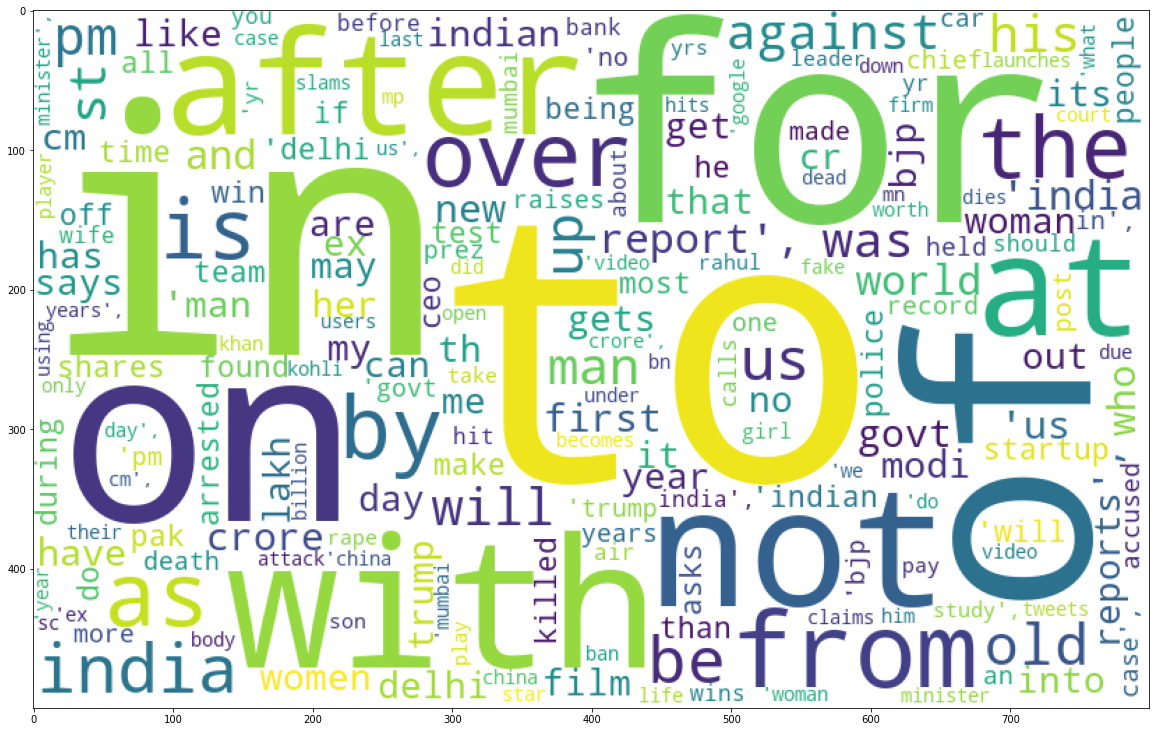

In [ ]:
y1 = df2['word'].value_counts()

wc = WordCloud(background_color = 'white', width = 800, height = 500)
cloud = wc.fit_words(dict(y1))
plt.figure(figsize=(20,15))
plt.imshow(cloud)

워드 클라우드로 한번 확인해봤습니다.

---

#학습 데이터와 테스트 데이터로 분할

##샘플 최대 길이 정하기

기사의 최소 길이 : 1
기사의 최대 길이 : 60
기사의 평균 길이 : 35.09983638377659
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299651426306644


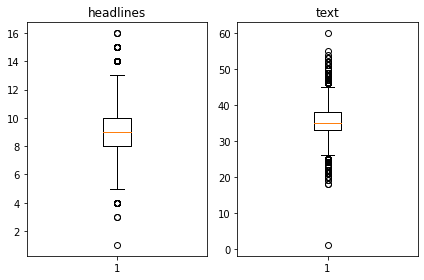

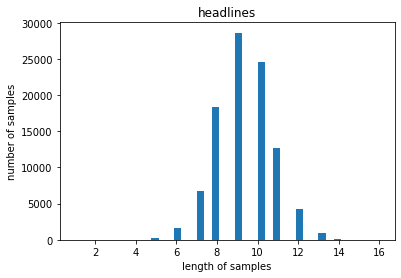

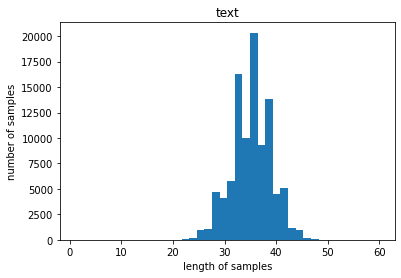

In [ ]:
import matplotlib.pyplot as plt

#text와 headlines 길이를 읽어서 분포로 출력해줍니다.
text_len = [len(s.split()) for s in df['text']]
headlines_len = [len(s.split()) for s in df['headlines']]

print('기사의 최소 길이 : {}'.format(np.min(text_len)))
print('기사의 최대 길이 : {}'.format(np.max(text_len)))
print('기사의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

그래프를 위에서부터 확인해보자면
- headlines과 실제 text의 길이 분포
- headlines 샘플 길이별 분포
- text 샘플 길이별 개수

**정규분포가 상당히 유사**해보입니다.

최대 길이는 모든 데이터가 포함될 수 있도록 지정하겠습니다.

In [ ]:
text_max_len = 60
headlines_max_len = 16

In [ ]:
#모든 데이터가 포함될 수 있도록 최대길이로 함수를 만든다.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, df['text'])
below_threshold_len(headlines_max_len,  df['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


---

##시작 토큰과 종료 토큰 추가

In [ ]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가
df['decoder_input'] = df['headlines'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['headlines'].apply(lambda x : x + ' eostoken')
df.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


**seq2seq로 훈련을 시키기 위해서는 시작 토큰과 종료 토큰을 추가**해야합니다.

**시작은 sostoken, 종료는 eostoken이라 정하고 앞,뒤로 추가**하겠습니다.

In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 

encoder_input = np.array(df['text']) # 인코더의 입력
decoder_input = np.array(df['decoder_input']) # 디코더의 입력
decoder_target = np.array(df['decoder_target']) # 디코더의 레이블

만들어준 데이터를 디코더의 입력과 타겟으로 넣어줍니다.

---

##데이터 전처리 - 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target, test_size = 0.2, random_state = 42)

print('학습 데이터 :', len(encoder_input_train))
print('학습 레이블 :', len(decoder_input_train))
print('테스트 데이터 :', len(encoder_input_test))
print('테스트 레이블 :', len(decoder_input_test))

학습 데이터 : 78720
학습 레이블 : 78720
테스트 데이터 : 19681
테스트 레이블 : 19681


**sklearn.model_selection의 train_test_split을 사용해 데이터를 분할**해줍니다.

---

#데이터 전처리 - 토크나이저

##단어 집합 만들기

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

**단어 집합을 src_tokenizer 저장**시켜놨습니다.

이번 프로젝트에서는 집합에 있는 **모든 단어를 사용**할것이 아니라,

빈도수가 낮은 단어는 학습데이터에서 제외시킬것입니다.

**10회 미만인 단어들은 이 데이터에 얼마만큼의 비중을 차지하고 있는지 확인**해보겠습니다.

In [ ]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69597
등장 빈도가 9번 이하인 희귀 단어의 수: 51164
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18433
단어 집합에서 희귀 단어의 비율: 73.5146629883472
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.549473209558479


- 등장 빈도가 10회 미만인 값은 73퍼를 차지함
- 하지만 등장빈도는 4퍼 밖에 되지않음

등장빈도가 10회 미만인 단어들은 정수인코딩에서 빼겠습니다.

단어집합은 위에 나와있는 **18433개와 유사한 18000으로 잡고 하겠습니다**.

In [ ]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[3])

[5, 837, 851, 1304, 1568, 130, 4181, 107, 838, 2497, 11914, 145, 1451, 696, 13779, 504, 377, 1304, 43, 130, 6897, 1500, 4181, 107, 380, 2936, 34, 3866, 100, 837, 1179, 14244, 461, 167, 695, 10754, 631]


---

##headlines 단어 집합 만들기

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30114
등장 빈도가 7번 이하인 희귀 단어의 수: 21332
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8782
단어 집합에서 희귀 단어의 비율: 70.83748422660557
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.953307249053901


In [ ]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[3])
print('target')
print('decoder ',decoder_target_train[3])

input
input  [1, 306, 7234, 1578, 5, 3417, 5202, 6, 52, 151]
target
decoder  [306, 7234, 1578, 5, 3417, 5202, 6, 52, 151, 2]


만약 전체 샘플에서 빈도수가 낮은 단어들로만 구성된 샘플이었을 경우는 빈 샘플이 되었을수도 있습니다.

하지만 **sostoken또는 eostoken이 추가된 상태이므로 길이가 0이 된 요약문의 실제 길이는 1로 나올것**입니다.

따라서 **요약문의 길이가 1인 경우의 인덱스를 따로 저장시키고 샘플들은 모두 삭제하도록 하겠습니다**.

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78719
훈련 레이블의 개수 : 78719
테스트 데이터의 개수 : 19681
테스트 레이블의 개수 : 19681


삭제할 훈련데이터의 갯수가 1개 밖에 없네요

제가 전처리를 기가막히게 잘 만든거 같습니다 허허허허ㅓ허허허허허ㅓ허허

---

##패딩추가

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding = 'post')

최대 길이보다 짧은 데이터는 뒤의 공간에 숫자 0을 넣어 최대 길이로 맞춰줍니다.
- 여기서 post는 뒷공간에 패딩을 추가시켜준다는 의미입니다

---

#추상적 요약 모델 설계 및 학습과 결과 확인

##seq2seq

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2304000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

노드 실습에 사용하였던 모델을 그대로 가지고 왔습니다.

**모델 구조가 Encoder 인풋 -> 임베딩 -> lstm1 -> lstm2 -> LSTM3 -> Decoder 인풋 ->임베딩 -> lstm**

이런식으로 나올줄 알았는데 다르게 나오는군요


##Attention 메커니즘 이용

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2304000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

어텐션 메커니즘을 사용하였습니다.

**seq2seq를 사용할때 어텐션과 같이 사용하게되면 더 좋은 효율을 낼 수 있다고 합니다**.

바로 학습으로 넘어가겠습니다.

---

##모델 학습

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 45s 102ms/step - loss: 4.1467 - val_loss: 3.8070
Epoch 2/50
308/308 [==============================] - 30s 96ms/step - loss: 3.6892 - val_loss: 3.5207
Epoch 3/50
308/308 [==============================] - 30s 96ms/step - loss: 3.4259 - val_loss: 3.3165
Epoch 4/50
308/308 [==============================] - 29s 96ms/step - loss: 3.2292 - val_loss: 3.1823
Epoch 5/50
308/308 [==============================] - 30s 96ms/step - loss: 3.0744 - val_loss: 3.0667
Epoch 6/50
308/308 [==============================] - 29s 96ms/step - loss: 2.9461 - val_loss: 2.9866
Epoch 7/50
308/308 [==============================] - 29s 96ms/step - loss: 2.8371 - val_loss: 2.9178
Epoch 8/50
308/308 [==============================] - 30s 96ms/step - loss: 2.7444 - val_loss: 2.8652
Epoch 9/50
308/308 [==============================] - 29s 96ms/step - loss: 2.6618 - val_loss: 2.8235
Epoch 10/50
308/308 [==============================] - 29s 96ms/step - loss: 2.58

여기서 **EarlyStopping은 특정 조건이 충족되면 학습을 멈추는 역할**을 합니다.

위에 코드는 손실(val_loss)가 줄어들지않고 2회정도 반복되면 학습을 멈추어 줍니다.

즉, 최적의 오차율을 찾을때, 많은 도움이 되는 라이브러리입니다.

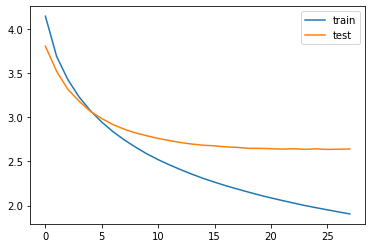

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

학습 결과를 시각화하였는데, 매우 아주 아름다운 곡선이 나타났네요

이제 결과를 확인해봅시다.

---

##인퍼런스 모델 구현

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

**seq2seq는 훈련할 때와 실제 동작할때의 방식이 다르므로 그에 맞게 모델 설계를 해야합니다**.

정답 문장이 없는 인퍼런스 단계에서는 만들어야할 문장의 길이 만큼 **디코더가 반복 구조로 동작**해야합니다.

때문에 **부득이하게 인퍼런스를 위한 모델을 별도로 설계**해주어야합니다.

이때는 **인코더와 디코더를 분리해서 설계**합니다.

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 만들어줍니다.

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

거의 다 왔습니다.

이제 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어 줍니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

이제 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보겠습니다.

**함수를 만들때는 패딩인 0과 시작 토큰 인덱스와 종료 토큰 인덱스를 출력에서 제외하고 만들겠습니다**.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

이제 마지막으로 결과를 출력 해보겠습니다.

**핵심 단어도 사용했는지 확인해보기 위해 원문에 단어를 저장한다음에 상위값 4개 정도를 뽑아서**

**원문에 노출이 많은 단어가 요약에도 들어있는지 까지 확인**해보겠습니다.


In [ ]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    dff = seq2text(encoder_input_test[i])
    test = dff.split()
    dff1 = pd.DataFrame({'word': test})
    x = dff1['word'].value_counts()
    dff2 = pd.DataFrame({'word': x})
    print(dff2['word'][:4])
    print()
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announced encouraging marks added academic year association said casting votes parents visit member schools confirm voted showing ink mark 
schools    2
marks      2
parents    2
votes      2
Name: word, dtype: int64

실제 요약 : taka students to get extra marks if parents vote in polls 
예측 요약 :  taka school speaker gets out from exam papers


원문 : syrian anti aircraft monday shot missiles two air bases syria state media said missiles targeted air base province another base northeast capital damascus comes days us uk france launched air strikes syrian chemical weapons facilities retaliation alleged chemical attack 
air         3
syrian      2
base        2
missiles    2
Name: word, dtype: int64

실제 요약 : syria shoots down missiles fired at two air 
예측 요약 :  israel missile attack missile kills new air strikes


원문 : dinosaur like creature fossil found excavat

**10개 정도를 뽑아봤을때, 문장이 잘 맞는것도 있긴 하지만 찾아보기가 어렵습니다**.

아마 몇몇개의 **단어를 추출하여 그것으로 새로운 문장을 만들라고 하기 때문인거 같습니다**.

문장속 핵심 단어를 보았을때, 포함이 된것도 있고 안된것도 있습니다.

완벽하게 저희가 원하는 결과를 아닌거 같습니다.

---

#추출적 요약

패키지 summa에서는 추출적 요약을 위한 모듈을 제공하고 있어 간단하게 구현할 수 있습니다.

먼저 라이브러리를 설치해줍니다.

In [ ]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.3 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=b98eed6dc238eba5109650f4b5f7ce807ada5de41e872388462ff68b833f724a
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


데이터를 제대로 불러왔는지 확인을 해줍니다.

In [ ]:
from summa.summarizer import summarize
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/pic/ex/news_summary_more.csv')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


---

##중복값과 결측값 확인

In [ ]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


---

##summarize를 사용한 추출적 요약

In [ ]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio = 0.7))
data.head()

,headlines,text,summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",The program and upGrad's 360-degree career sup...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,"Pranav Kaushik, a Delhi techie, bagged this re..."
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",The plan provides life cover up to the age of ...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다.

ratio로 문장 비율을 선택할 수 있습니다.

**초반에는 0.3으로 진행하였는데, 빈문장으로 나와서 0.7로 수정**하였습니다.

In [ ]:
for i in range(0, 10):
    print("test :", data['text'][i])
    print("headlines :", data['headlines'][i])
    print("summary :", data['summary'][i])
    print("\n")

test : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
headlines : upGrad learner switches to career in ML & Al with 90% salary hike
summary : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


test : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats,

결과는 대체로 추상적 요약보다는 좋게 나왔습니다.

기존에 완성되어있던 문장을 그대로 읽고 거기서 잘랐기 때문이라고 생각합니다.

---

#simplet5를 사용한 파이토치 모델 구현(캐글 참고)

이번에는 simplet5라는 라이브러리를 이용하여 간단하게 추상적 모델을 만들어보겠습니다.

In [ ]:
import numpy as np
import pandas as pd 
import os

#filename에 csv파일 경로를 지정합니다.
for dirname, _, filenames in os.walk('/content/drive/MyDrive/pic/ex'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/pic/ex/news_summary.csv
/content/drive/MyDrive/pic/ex/news_summary_more.csv


simplet 라이브러리를 설치해줍니다.

In [ ]:
!pip install simplet5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 3.5 MB 51.3 MB/s 
     |████████████████████████████████| 527 kB 65.1 MB/s 
     |████████████████████████████████| 952 kB 66.0 MB/s 
     |████████████████████████████████| 140 kB 71.3 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
     |████████████████████████████████| 829 kB 56.2 MB/s 
     |████████████████████████████████| 409 kB 57.4 MB/s 
     |████████████████████████████████| 880 kB 63.7 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
     |████████████████████████████████| 1.1 MB 56.4 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 69.1 MB/s 
     |████████████████████████████████| 271 kB 69.1 MB/s 
  Created wheel for simplet5: filena

In [ ]:
from sklearn.model_selection import train_test_split
import random
import torch
import re
import os
import string

import pandas as pd

from simplet5 import SimpleT5

---

##모델 셋팅

클래스를 사용하여 한번에 구현하는 과정이 캐글에 나와있었습니다.

링크는 밑에 참고자료에 기재해두겠습니다.

In [ ]:
#클래스안에서 디바이스에 gpu할당 및 학습 파일 불러오기, 컬럼 나누어주기
#에포크설정, 배치사이즈, 길이 설정을 한번에 해준다.

class Settings:

    MODEL_TYPE = "t5"
    MODEL_NAME = "t5-base"

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # training data directory
    TRAIN_DATA = "/content/drive/MyDrive/pic/ex/news_summary.csv"

    Columns = ['headlines', 'text']

    USE_GPU = None
    if str(DEVICE) == "cuda":
        USE_GPU=True
    else:
        USE_GPU = False

    EPOCHS = 5

    encoding = 'latin-1'
    columns_dict = {"headlines": "target_text", "text": "source_text"}
    df_column_list = ['source_text', 'target_text']
    SUMMARIZE_KEY = "summarize: "
    SOURCE_TEXT_KEY = 'source_text'
    TEST_SIZE = 0.2
    BATCH_SIZE = 8
    source_max_token_len = 128
    target_max_token_len = 50
    train_df_len = 5000
    test_df_len = 100

---

##데이터 전처리

데이터에서 공백, 소문자, 특수문자 등등을 처리 처리해줍니다.

기존의 컬럼명의 변경하고 summarize를 접두사로 사용합니다.


In [ ]:
class Preprocess:
    def __init__(self):
        self.settings = Settings

    def clean_text(self, text):
        text = text.lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        return text

    def preprocess_data(self, data_path):
        df = pd.read_csv(data_path, encoding=self.settings.encoding, usecols=self.settings.Columns)
        #기존의 컬럼명의 위에서 지정한 이름으로 변경
        df = df.rename(columns=self.settings.columns_dict)
        df = df[self.settings.df_column_list]
        #SUMMARIZE를 접두사로 설정
        df[self.settings.SOURCE_TEXT_KEY] = self.settings.SUMMARIZE_KEY + df[self.settings.SOURCE_TEXT_KEY]

        return df

---

##모델 정의

모델의 정의하는 클래스를 만들어줍니다.

In [ ]:
class T5Model:
    def __init__(self, model_type, model_name):
        self.model = SimpleT5()
        self.model.from_pretrained(model_type=model_type,
                                   model_name=model_name)

    #위에 클래스에서 지정한 이름과 타입과 경로, 디바이스를 할당시켜줍니다.
    def load_model(self, model_type, model_path, use_gpu: bool):
        try:
            self.model.load_model(
                model_type=model_type,
                model_dir=model_path,
                use_gpu=use_gpu
            )
        #예외 처리하는 함수를 정의
        except BaseException as ex:
            print("모델 로드중 오류 발생", str(ex))

---

##모델 학습 시키기

대부분의 구현들은 위에서 클래스 형식으로 지정해놔서 가져와서 쓰기만 하면됩니다.

벌써 학습까지 오다니 상당히 빠른거처럼 느껴지지 않나요?

In [ ]:
class Train:
    def __init__(self):
        self.settings = Settings
        self.preprocess = Preprocess()

        self.t5_model = None

    def __initialize(self):
        try:
            self.t5_model = T5Model(model_name=self.settings.MODEL_NAME,
                                    model_type=self.settings.MODEL_TYPE)

        except BaseException as ex:
            print("모델 로드중 오류 발생 ", str(ex))

    def set_seed(self, seed_value=42):
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    def train(self, df):
        try:
            train_df, test_df = train_test_split(df, test_size=self.settings.TEST_SIZE)

            #모델 학습 구현 summarize 순서로 뽑아낸다.
            self.t5_model.model.train(train_df=train_df[:self.settings.train_df_len],
                                      eval_df=test_df[:self.settings.test_df_len],
                                      source_max_token_len=self.settings.source_max_token_len,
                                      target_max_token_len=self.settings.target_max_token_len,
                                      batch_size=self.settings.BATCH_SIZE, max_epochs=self.settings.EPOCHS,
                                      use_gpu=self.settings.USE_GPU)

        except BaseException as ex:
            print("모델 로드중 오류 발생 ", str(ex))

    def run(self):
        try:
            print("데이터 세트 로드 및 준비")
            df = self.preprocess.preprocess_data(self.settings.TRAIN_DATA)
            print(df.head())
            print("T5 모델 로드 및 초기화")
            self.__initialize()
            print("모델 로드 완료")

            print("학습 시작")
            self.set_seed()
            self.train(df)
            print("학습 끝")

        except BaseException as ex:
            print("예외발생", str(ex))

In [ ]:
print(Settings.USE_GPU)
print(Settings.DEVICE)

True
cuda


In [ ]:
t= Train()
t.run()

데이터 세트 로드 및 준비
                                         source_text  \
0  summarize: The Administration of Union Territo...   
1  summarize: Malaika Arora slammed an Instagram ...   
2  summarize: The Indira Gandhi Institute of Medi...   
3  summarize: Lashkar-e-Taiba's Kashmir commander...   
4  summarize: Hotels in Maharashtra will train th...   

                                         target_text  
0  Daman & Diu revokes mandatory Rakshabandhan in...  
1  Malaika slams user who trolled her for 'divorc...  
2  'Virgin' now corrected to 'Unmarried' in IGIMS...  
3  Aaj aapne pakad liya: LeT man Dujana before be...  
4  Hotel staff to get training to spot signs of s...  
T5 모델 로드 및 초기화


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


모델 로드 완료
학습 시작


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/drive/MyDrive/pic/ex/lightning_logs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

학습 끝


---

##모델 결과 확인

다음으로는 이번 모델이 제대로 예측을 하는지 확인해보겠습니다.

먼저 전체 text를 변수에 할당 시켜줍니다.

In [ ]:
text_to_summarize="""summarize: Twitter’s interim resident grievance officer for India has stepped down, leaving the micro-blogging site without a grievance official as mandated by the new IT rules to address complaints from Indian subscribers, according to a source.

The source said that Dharmendra Chatur, who was recently appointed as interim resident grievance officer for India by Twitter, has quit from the post.

The social media company’s website no longer displays his name, as required under Information Technology (Intermediary Guidelines and Digital Media Ethics Code) Rules 2021.

Twitter declined to comment on the development.

The development comes at a time when the micro-blogging platform has been engaged in a tussle with the Indian government over the new social media rules. The government has slammed Twitter for deliberate defiance and failure to comply with the country’s new IT rules.
"""

입력한 모델을 가중치를 가지고 옵니다.

그 가중치를 사용하여 테스트를 진행할 것입니다.

In [ ]:
! ( cd outputs; ls )

simplet5-epoch-0-train-loss-1.5522-val-loss-1.3749
simplet5-epoch-1-train-loss-1.1361-val-loss-1.3279
simplet5-epoch-2-train-loss-0.9101-val-loss-1.3548
simplet5-epoch-3-train-loss-0.7325-val-loss-1.4313
simplet5-epoch-4-train-loss-0.5997-val-loss-1.4852


모델에 가중치를 할당 시킵니다.

In [ ]:
best_weight = "./outputs/simplet5-epoch-4-train-loss-0.5997-val-loss-1.4852"

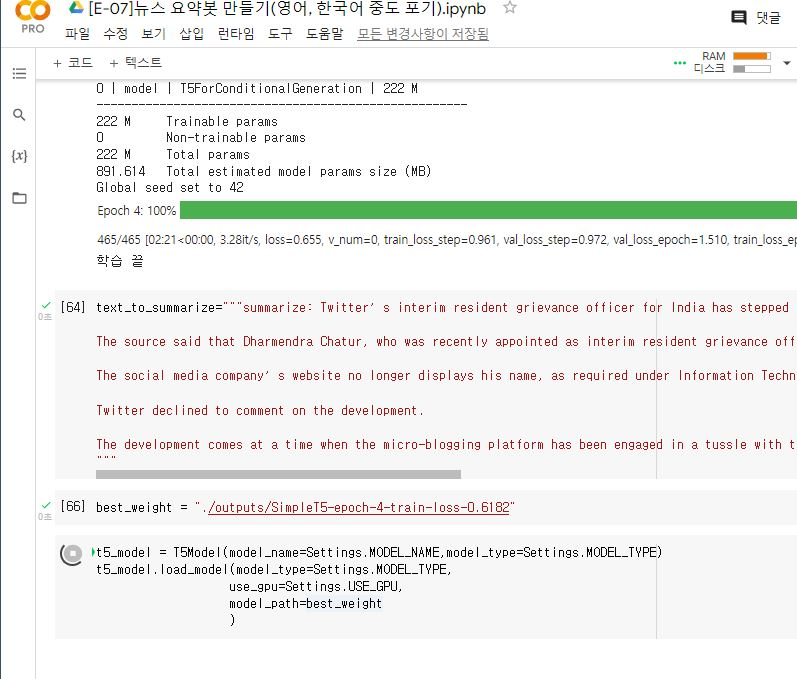

이때 진짜 RAM이 터질뻔 했습니다. ㅠㅠ

되도록이면 코랩에서 사용하지 마시길 바랍니다.

In [ ]:
t5_model = T5Model(model_name=Settings.MODEL_NAME,model_type=Settings.MODEL_TYPE)
t5_model.load_model(model_type=Settings.MODEL_TYPE,
                   use_gpu=Settings.USE_GPU,
                   model_path=best_weight
                   )

In [ ]:
t5_model.model.predict(text_to_summarize)

["Twitter's interim resident grievance officer for India steps down"]

제가 직접 만든 모델보다 더 잘 나온거 같은건 기분 탓인가요?


---

#한국어로 된 기사를 요약해보자!

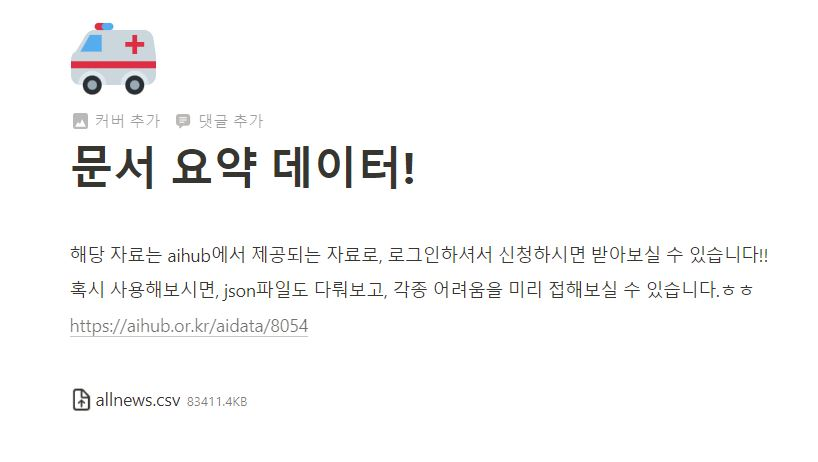

이쪽에다가 퍼실님이 올려주셨네요

아유 이런걸 다 허허허허ㅓ허허허허헣 ㅠㅠㅠㅠㅠㅠㅠㅠㅠ

한번 해보겠습니다.

데이터를 다운받고 잘 나오는지 출력해보겠습니다.

In [ ]:
ko_df = pd.read_csv('/content/drive/MyDrive/pic/ex1/allnews.csv')
ko_df.head()

,신문사,분류,제목,본문,날짜 및 시간
0,프레시안,경제,뉴라운드 협상 이제부터다 - WTO 국민연대 장원석 집행위원장의 협상 참관기,지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료...,['2001-11-21 09:53:00']
1,프레시안,세계,"미, 이슬람권 대상 방송국 설립 추진 - 본격 선전전 나서",미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 ...,['2001-11-21 09:53:00']
2,프레시안,정치,개혁신당 운동 젊은 의원들이 밀어붙여라 - 이부영 한나라당 부총재 인터뷰,한나라당 이부영 부총재는 19일 프레시안과 인터뷰를 갖고 개혁신당 운동에 대해 ...,['2001-11-21 09:53:00']
3,프레시안,세계,잊혀진 나라 '아프간' <6ㆍ끝> - 누가 이 전쟁을 멈출 것인가,아프간의 기아 참상을 영화로 찍기 위해 방글라데시 유엔 대표인 카말 후세인 박사...,['2001-11-20 10:01:00']
4,프레시안,세계,"미국, 고문 합법화. 비밀재판 추진 - ""미국이외는 야만이라는 미국의 야만적 사고""",“테러범들에 대한 고문을 합법화해야 한다.”\n “테러범들은 비밀리에 항공모함...,['2001-11-20 10:01:00']


---

##추출적 모델 구현

저희가 알아야 할건 제목과 본문이면 될꺼 같습니다.

나머지는 지워주겠습니다.

In [ ]:
ko_df = ko_df.drop('신문사',axis = 1)
ko_df = ko_df.drop('분류',axis = 1)
ko_df = ko_df.drop('날짜 및 시간',axis = 1)

ko_df.head()

,제목,본문
0,뉴라운드 협상 이제부터다 - WTO 국민연대 장원석 집행위원장의 협상 참관기,지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료...
1,"미, 이슬람권 대상 방송국 설립 추진 - 본격 선전전 나서",미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 ...
2,개혁신당 운동 젊은 의원들이 밀어붙여라 - 이부영 한나라당 부총재 인터뷰,한나라당 이부영 부총재는 19일 프레시안과 인터뷰를 갖고 개혁신당 운동에 대해 ...
3,잊혀진 나라 '아프간' <6ㆍ끝> - 누가 이 전쟁을 멈출 것인가,아프간의 기아 참상을 영화로 찍기 위해 방글라데시 유엔 대표인 카말 후세인 박사...
4,"미국, 고문 합법화. 비밀재판 추진 - ""미국이외는 야만이라는 미국의 야만적 사고""",“테러범들에 대한 고문을 합법화해야 한다.”\n “테러범들은 비밀리에 항공모함...


In [ ]:
print(len(ko_df))

38053


In [ ]:
print('본문에서 중복을 배제한 유일한 샘플의 수 :', ko_df['본문'].nunique())
print('제목에서 중복을 배제한 유일한 샘플의 수 :', ko_df['제목'].nunique())

본문에서 중복을 배제한 유일한 샘플의 수 : 35940
제목에서 중복을 배제한 유일한 샘플의 수 : 36039


**결측치가 제목에 1개, 본문에 45개가 있다**고 합니다.

어떤 결측치인지 **확인이 불가능하고 데이터량이 방대하기 때문에 그냥 결측치가 존재하는 행을 삭제**하겠습니다.

In [ ]:
ko_df.isna().sum()

제목     1
본문    45
dtype: int64

In [ ]:
ko_df = ko_df.dropna()

In [ ]:
ko_df.isna().sum()

제목    0
본문    0
dtype: int64

**summa에 존재하는 summarize를 통하여 추상적 요약을 해보겠습니다**.

In [ ]:
from summa.summarizer import summarize

In [ ]:
ko_df['summarize'] = ko_df['본문'].apply(lambda x: summarize(x, ratio=0.5))
ko_df.head()

,제목,본문,summarize
0,뉴라운드 협상 이제부터다 - WTO 국민연대 장원석 집행위원장의 협상 참관기,지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료...,지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료회의...
1,"미, 이슬람권 대상 방송국 설립 추진 - 본격 선전전 나서",미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 ...,미국 인터넷 신문 살롱닷컴(salon.com)은 19일(현지시간) “미국정부가 회교...
2,개혁신당 운동 젊은 의원들이 밀어붙여라 - 이부영 한나라당 부총재 인터뷰,한나라당 이부영 부총재는 19일 프레시안과 인터뷰를 갖고 개혁신당 운동에 대해 ...,한나라당 이부영 부총재는 19일 프레시안과 인터뷰를 갖고 개혁신당 운동에 대해 “밑...
3,잊혀진 나라 '아프간' <6ㆍ끝> - 누가 이 전쟁을 멈출 것인가,아프간의 기아 참상을 영화로 찍기 위해 방글라데시 유엔 대표인 카말 후세인 박사...,"나는 북부동맹이 장악한 아프간 북부와 탈레반이 지배하는 칸다하르, 두 곳을 모두 가..."
4,"미국, 고문 합법화. 비밀재판 추진 - ""미국이외는 야만이라는 미국의 야만적 사고""",“테러범들에 대한 고문을 합법화해야 한다.”\n “테러범들은 비밀리에 항공모함...,"“테러범들에 대한 고문을 합법화해야 한다.”\n""고문은 惡한 것이지만, 상대적으로 ..."


In [ ]:
for i in range(0, 10):
    print("본문 :", ko_df['본문'][i])
    print("\n")
    print("제목 :", ko_df['제목'][i])
    print("\n")
    print("요약 :", ko_df['summarize'][i])
    print("\n")

본문 :   지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료회의에서 우리의 관심 사항은 시장접근, 국내보조, 비교역적 관심사항(NTC) 등이었다.
  
  특히 농업 부문 협상의 성패는 그야말로 농업이 사느냐 죽느냐의 관건이라 해도 과언이 아니었다. 일례를 들어, 현재 농축산물의 평균관세는 60% 수준인데 수출강대국의 요구대로 철폐 내지 대폭 감축한다면, 우리의 가격경쟁력은 50-60% 떨어지게 되기 때문이다.
  
  이를 극복하기 위해서는 기술, 경영, 유통 등의 구조혁신에 의하여 생산비를 50-60% 이상 줄여야 하는데, 이에는 20년 내지 30년 이상 소요된다. 이처럼 순간의 협상이 엄청난 결과를 가져오는 것이다.
  
  그런데도 냉혹한 국제환경 속에서 우리의 대응책은 골리앗에 대항하여 싸우는 다윗처럼 비쳐졌다. 그러므로 정부 혼자만의 힘으로는 안 되고, 국민적 힘과 지혜를 모아 함께 대응해야 하는 사안이었다.
  
  이러한 처지는 강대국도 마찬가지이기는 하다. 유럽연합(EU)은 농민단체의 요구와 시위를 교묘하게 이용했다. 일본도 의원들과 전국농협중앙회 등 NGO의 지원을 받아가며 세계무역기구 사무국 실력자들을 만나 국내여론을 전하고 입장을 표명하는 등 동분서주하였다. 제3세계에서는 정부의 협상력을 보완하기 위해 민간전문가들을 정부대표로 위장시켜 내세우기도 했다.
  
  미국마저 협상대표들은 국내 압력단체들을 설득할 수 있는 용어의 선택에 신경 쓰면서, 우리나라 등 NTC(농업의 비교역적 관심사항) 그룹 대표들에게 양해를 구하는 등 온갖 수단과 방법을 동원하는 것을 전해 들으면서, 초강대국 미국 역시 다자간 협상장인 WTO 협상에서는 한계가 있다는 것을 느꼈다.
  
  여하튼 WTO 협상은 정부, 의회, NGO들이 때로는 비판하고 때로는 공동대응하면서, 국가와 국민, 계층의 이익을 관철시키기 위해 추호의 허술함도 보여서는 안 되는 전쟁과도 같은 것이었다.
  
  WTO 협상 농업부문의 3대 목표
  
  당초에 

제대로 된 것인지 아닌지 잘 모르겠네요

미국 기사보다 훨씬 긴거 같습니다.

전처리부터 부족한 점이 많이보여 추상적 요약은 구현하지 못했습니다.

추후에 다시 시도해보겠습니다.

---

#마무리

이번 노드에서는 추상적 요약과 추출적 요약을 해보았습니다.

**추상적 요약**

원문 : egyptian activist actress amal given sentence two years charges spreading false news uploading video facebook wherein alleged faced sexual harassment bank charged video social media publicly incite government already spent days prison 

실제 요약 : egypt actress gets yrs jail for fake news on sexual harassment 

예측 요약 :  fb faces cr for sharing years in fb




**추상적 요약 결과를 확인해보면 단어(키워드)를 찾아내고 그것을 요약할 수 있는 새로운 단어를 만들어 요약**을 합니다.

그렇기 때문에 **본문을 내용과는 연관성이 떨어지는 이상한 문장이 생성**되기도 합니다.


**추출적 요약**

test : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


headlines : upGrad learner switches to career in ML & Al with 90% salary hike


summary : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.




그에 비해 **추출적 요약**은 추상적 요약과는 달리 **연관성과 일관성을 가지고 요약이 됩니다**.

하지만 **뉴스의 헤드라인으로 사용하기에는 적합하지 않은거 같습니다**.

왜냐면 **Summa를 활용한 요약문의 경우 ratio가 0.4보다 작아질 경우 결과가 나오지 않았습니다**.

혹은 **빈 리스트만 반환되는 경우도 있었습니다**.

**완전히 요약된 문장을 원하는것이 목적이라면 전처리와 모델 학습을 개선시킨 추상적 모델을 사용**하는게 좋다고 생각합니다.

simplet5 라이브러리를 사용해서 만든 모델만 봐도 성능이 놀랄만큼 향상되었습니다.

다른 문제점들도 몇가지 이야기를 하면
- train_loss는 많이 줄었지만 val_loss는 그렇지 않았다.
- 불용어는 과연 다 제거하는 것이 적합한지
- 태깅을 통하여 특정 문자를 살리는것이 가능한지
- loss값 말고 모델을 정확도를 판별하는것이 없는가?

추후의 공부를 통해서 전처리와 태깅을 잘만 사용한다면 네이버 뺨을 후릴 수 있는 모델을 만들 수 있을꺼라 자부합니다.

태깅을 말하니 구현하지 못한 기능들이 많아서 너무 아쉬웠습니다.

프로젝트에서 **태깅을 한 이유가 고유명사는 추상적 요약에서 남겨두고 싶었지만, 구현을 하지 못하였습니다**.(제가 실력이 많이 없어서..)

그리고 **한국어 기사 요약은 다른 영역**이었습니다.

**뛰어 쓰기와 은, 는, 이, 가 같은 단어를 문장에 어떤식으로 위치 시키는지 감을 못잡았습니다**.

**불용어로 무엇을 선택해야하는지, 품사 태깅은 어떻게 하는것인지 처음 접하는 영역**이었습니다.

마지막으로 아쉬운 점은 노드에 나온 코드가 아닌 직접 코드를 바꿔보고 싶었고, 새롭게 짜고 싶었지만 시도조차 하지 못한것 입니다.

---

#참고자료

https://mkjjo.github.io/python/2019/07/09/english_preprocessing.html

https://github.com/ai-rtistic/AIFFEL-Project/blob/master/Exploration/EP10_News_Summarization.ipynb

https://www.kaggle.com/code/raryan/t5-abstractive-text-summarization